In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import time

from itertools import product
import qutip as qt

import h5py
from datetime import datetime
import sys
import os
import shutil
import importlib

sys.path.append(r"C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1")
sys.path.append(r"C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\8Q_Triangle_Lattice_v1\current_measurements")


import current_measurements.src.src_current_measurement_simulations
importlib.reload(current_measurements.src.src_current_measurement_simulations);
from current_measurements.src.src_current_measurement_simulations import CurrentMeasurementSimulation

import current_measurements.src.src_current_measurement_simulations_particle_sector
importlib.reload(current_measurements.src.src_current_measurement_simulations_particle_sector);
from current_measurements.src.src_current_measurement_simulations_particle_sector import CurrentMeasurementSimulationParticleSector


In [3]:
config_filename = 'current_correlations_config.json'

with open(config_filename, 'r') as f:
    config = json.load(f)

coupling_point = 'coupling_point_2'


coupling_point_config = config[coupling_point]


In [4]:


correlation_pairs = []
for i in range(1, 8):
    for j in range(i + 2, 8):
        correlation_pairs.append(((i, i+1), (j,j+1)))



In [5]:
correlation_pair_to_simulation = {}


In [7]:
### extract simulation data

simulation_config = coupling_point_config['simulation_config']

num_levels = simulation_config['num_levels']
num_qubits = simulation_config['num_qubits']
num_particles = simulation_config['num_particles']

U = simulation_config['U'] * 2  *np.pi
times = np.linspace(simulation_config['time_start'], simulation_config['time_stop'], simulation_config['time_num_points'])

J = []
J_parallel = []

psi0 = simulation_config['psi0']
T1 = simulation_config['T1']
T2 = simulation_config['T2']

coupling_dict = coupling_point_config['coupling']

for i in range(num_qubits-1):
    J_key = f'J_{i+1}{i+2}'
    J_parallel_key = f'J_{i+1}{i+3}'

    if J_key in coupling_dict:
        J.append(coupling_dict[J_key])

    if J_parallel_key in coupling_dict:
        J_parallel.append(coupling_dict[J_parallel_key])

if not len(J) == num_qubits - 1:
    raise ValueError(f'coupling strengths J not properly specified in config file. Needs all pairs J_<i><i+1>. Given length: {len(J)}')

if not len(J_parallel) == num_qubits - 2:
    raise ValueError(f'coupling strengths J_parallel not properly specified in config file. Needs all pairs J_<i><i+2>. Given length: {len(J_parallel)}')

J = np.array(J)*2*np.pi
J_parallel = np.array(J_parallel)*2*np.pi



In [8]:
### create inital state a different way


num_levels = 3
num_qubits = 8
num_particles = 4

a = qt.destroy(num_levels)
annihilation_operators = []
for i in range(num_qubits):
    operator_list = [qt.qeye(num_levels) for j in range(num_qubits)]
    operator_list[i] = a
    annihilation_operators.append(qt.tensor(operator_list))



H = 0

# J = 6 * 2 * np.pi
# J_parallel = 2 * J
# U = -200 * 2 * np.pi

for i in range(num_qubits):
    a_i = annihilation_operators[i]

    if i < num_qubits - 1:
        a_j = annihilation_operators[i+1]
        H += -J[0] * (a_i.dag() * a_j + a_j.dag() * a_i)

    if i < num_qubits - 2:
        a_j = annihilation_operators[i+2]
        H += -J_parallel[0] * (a_i.dag() * a_j + a_j.dag() * a_i)

    H += U/2 * a_i.dag()*a_i*(a_i.dag()*a_i - 1)



In [9]:
number_operators = []
current_operators = []

for i in range(num_qubits):
    a_i = annihilation_operators[i]

    number_operators.append(a_i.dag()*a_i)

    if i < num_qubits - 1:
        a_j = annihilation_operators[i+1]
        current_operators.append(1j*J[0]*(a_i.dag()*a_j - a_j.dag()*a_i))
    
total_number_operator = sum(number_operators)

In [10]:
eigenenergies, eigenstates = H.eigenstates()

particle_number_to_eigenenergy = {}
particle_number_to_eigenstate = {}

for i in range(len(eigenstates)):
    particle_number = int(round(qt.expect(total_number_operator, eigenstates[i])))
    if particle_number not in particle_number_to_eigenenergy:
        particle_number_to_eigenenergy[particle_number] = []
        particle_number_to_eigenstate[particle_number] = []

    particle_number_to_eigenenergy[particle_number].append(eigenenergies[i])
    particle_number_to_eigenstate[particle_number].append(eigenstates[i])

for particle_number in particle_number_to_eigenenergy:
    particle_number_to_eigenenergy[particle_number] = np.array(particle_number_to_eigenenergy[particle_number])
    particle_number_to_eigenstate[particle_number] = np.array(particle_number_to_eigenstate[particle_number])

    sorted_indices = np.argsort(particle_number_to_eigenenergy[particle_number])

    particle_number_to_eigenenergy[particle_number] = particle_number_to_eigenenergy[particle_number][sorted_indices]
    particle_number_to_eigenstate[particle_number] = particle_number_to_eigenstate[particle_number][sorted_indices]

In [11]:
eigenstate = particle_number_to_eigenstate[4][-1]
psi0_state = eigenstate

In [17]:
psi0 = eigenstate
times = np.linspace(0, 0.15, 101)
e_ops = number_operators

covariance_sums = []

for p in range(len(correlation_pairs)):
    H_BS = 0


    correlation_pair = correlation_pairs[p]
    print(correlation_pair)
    measurement_detuning = coupling_point_config['data_config'][str(correlation_pair)]['measurement_detunings']


    for i in range(num_qubits):
        a_i = annihilation_operators[i]

        if i < num_qubits - 1:
            a_j = annihilation_operators[i+1]
            H_BS += -J[0] * (a_i.dag() * a_j + a_j.dag() * a_i)

        if i < num_qubits - 2:
            a_j = annihilation_operators[i+2]
            H_BS += -J_parallel[0] * (a_i.dag() * a_j + a_j.dag() * a_i)
        H_BS += U/2 * a_i.dag()*a_i*(a_i.dag()*a_i - 1)
        
        H_BS += a_i.dag()*a_i*measurement_detuning[i]


    result = qt.sesolve(H_BS, psi0, times)

    populations = np.zeros((num_qubits, len(times)))

    for i in range(num_qubits):
        populations[i,:] = qt.expect(number_operators[i], result.states)

    covariances = np.zeros((num_qubits, num_qubits, len(times)))

    for i in range(num_qubits):
        for j in range(num_qubits):
            covariances[i,j,:] = qt.expect(number_operators[i] * number_operators[j], result.states)


    

    readout_qubits_1, readout_qubits_2 = correlation_pair

    readout_pair_1 = [q - 1 for q in readout_qubits_1]
    readout_pair_2 = [q - 1 for q in readout_qubits_2]


    covariance_sum = 0

    covariance_sum += covariances[readout_pair_1[0], readout_pair_2[0], :] - populations[readout_pair_1[0], :] * populations[readout_pair_2[0], :]
    covariance_sum -= covariances[readout_pair_1[0], readout_pair_2[1], :] - populations[readout_pair_1[0], :] * populations[readout_pair_2[1], :]
    covariance_sum -= covariances[readout_pair_1[1], readout_pair_2[0], :] - populations[readout_pair_1[1], :] * populations[readout_pair_2[0], :]
    covariance_sum += covariances[readout_pair_1[1], readout_pair_2[1], :] - populations[readout_pair_1[1], :] * populations[readout_pair_2[1], :]


    covariance_sums.append(covariance_sum)

covariance_sums = np.array(covariance_sums)












((1, 2), (3, 4))


((1, 2), (4, 5))
((1, 2), (5, 6))
((1, 2), (6, 7))
((1, 2), (7, 8))
((2, 3), (4, 5))
((2, 3), (5, 6))
((2, 3), (6, 7))
((2, 3), (7, 8))
((3, 4), (5, 6))
((3, 4), (6, 7))
((3, 4), (7, 8))
((4, 5), (6, 7))
((4, 5), (7, 8))
((5, 6), (7, 8))


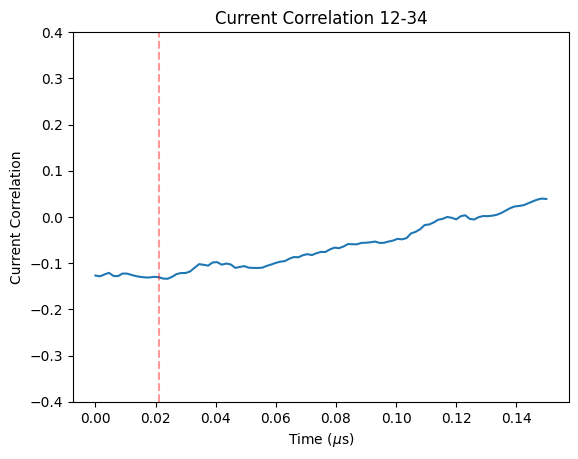

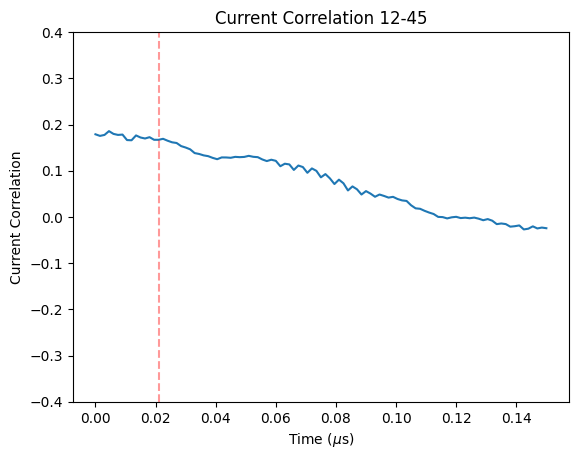

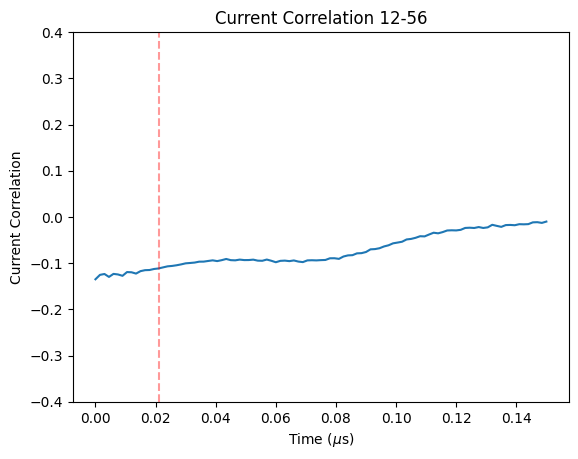

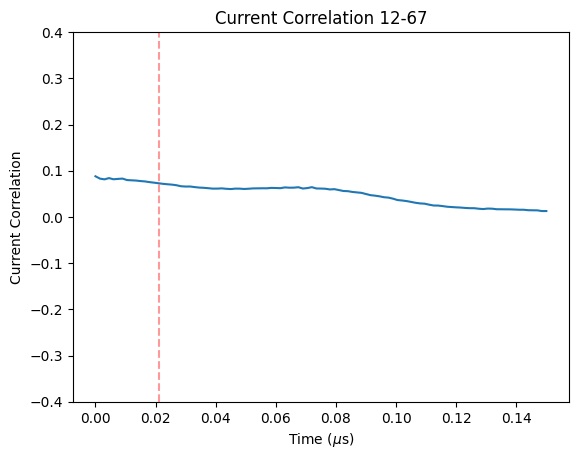

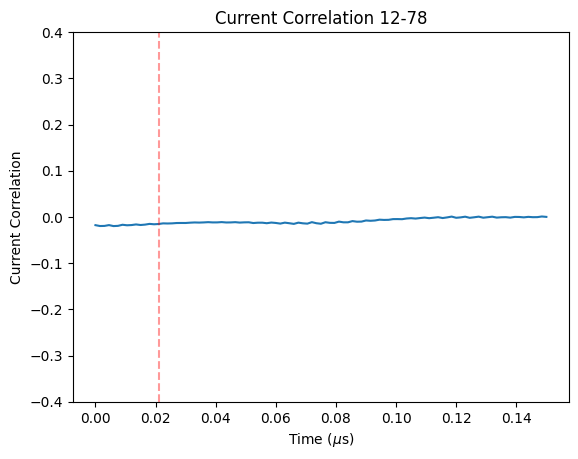

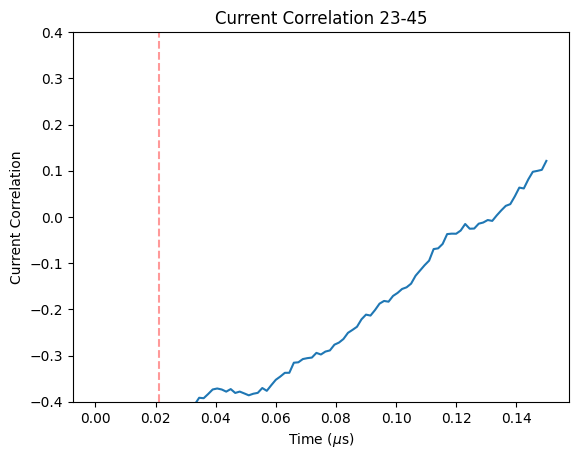

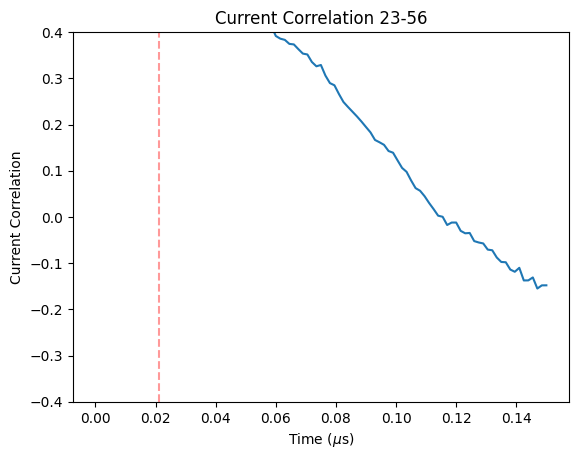

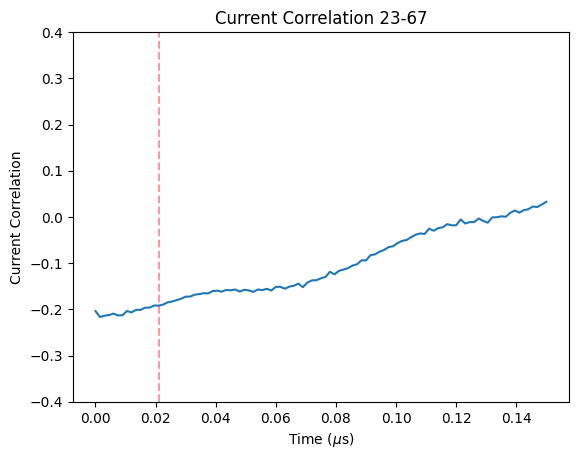

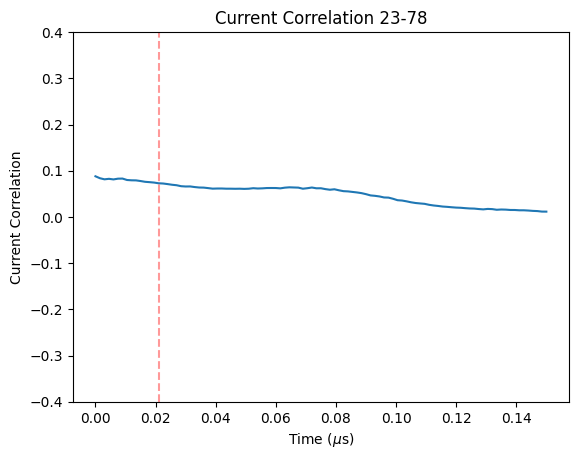

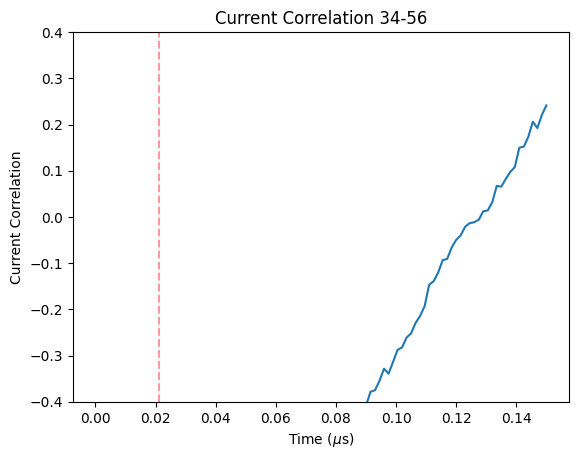

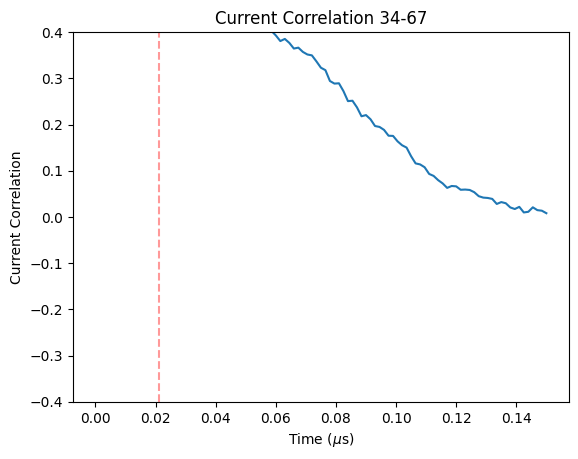

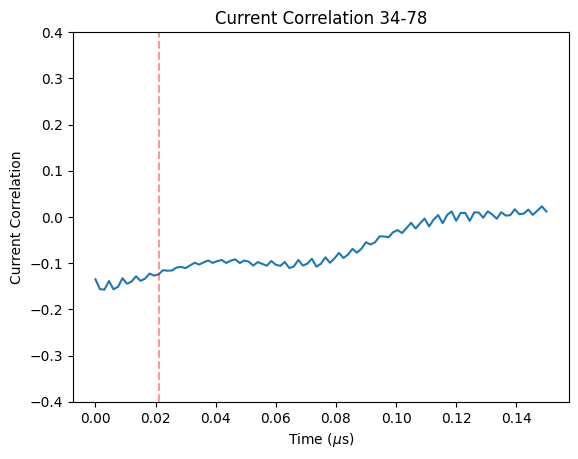

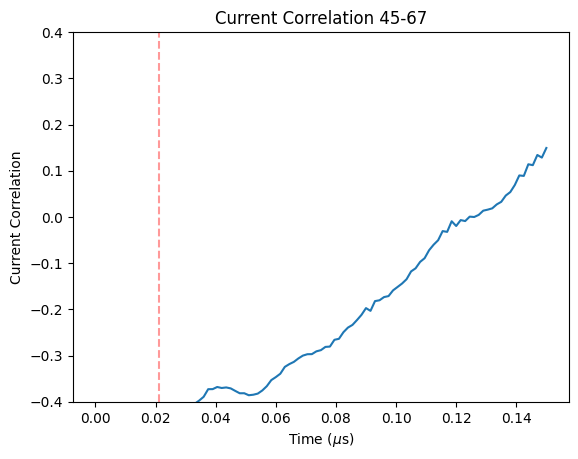

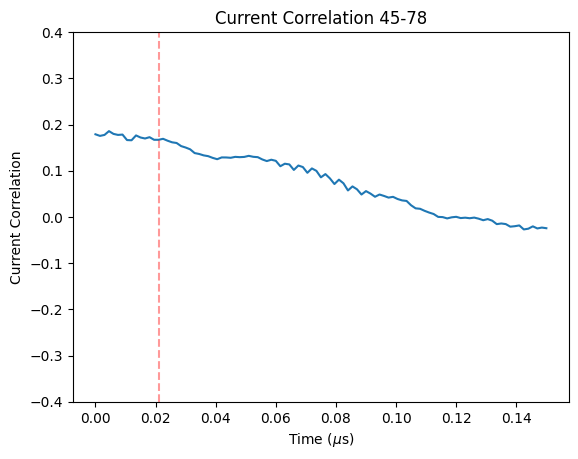

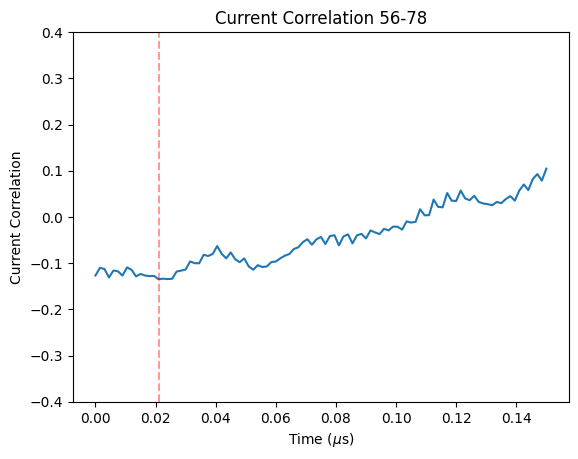

In [19]:
beamsplitter_time = 0.021

for p in range(len(correlation_pairs)):
    plt.plot(times, covariance_sums[p])
    plt.xlabel('Time ($\mu$s)')
    plt.ylabel('Current Correlation')

    plt.axvline(beamsplitter_time, color='r', alpha=0.4, linestyle='--', label='Beamsplitter Time')

    plt.ylim(-0.4, 0.4)

    readout_pair_1, readout_pair_2 = correlation_pairs[p]
    q1, q2 = readout_pair_1
    q3, q4 = readout_pair_2

    plt.title(f'Current Correlation {q1}{q2}-{q3}{q4}')
    plt.show()